# 1 - Our Goal : 

In this project, we will use K-means clustering and PCA to perform customer segmentation based on their purchasing behavior in an e-commerce dataset. The goal is to identify distinct groups of customers with similar preferences and behaviors, enabling personalized marketing strategies and recommendations. 

Extract relevant features from the dataset that capture customer behavior, such as purchase history, order frequency, total spending, etc. Calculate additional metrics if necessary, such as recency of purchase or average basket size. Dimensionality Reduction with PCA: Apply PCA to reduce the dimensionality of the feature space while retaining the most informative features

Determining Optimal Number of Clusters: Use the elbow method or silhouette analysis to determine the optimal number of clusters for K-means. Experiment with different values of K and evaluate the clustering results. K-means Clustering: Perform K-means clustering on the reduced feature space. Assign each customer to a cluster based on their feature values. Analyze the resulting clusters and interpret the characteristics of each segment. Cluster Profiling: Profile each cluster by calculating cluster-specific metrics, such as average spending, purchase frequency, or popular product categories. Identify the key characteristics and behaviors that distinguish each cluster. Visualization: Visualize the clusters and their separation using scatter plots or other suitable techniques. Plot the clusters based on the reduced feature space to understand the distribution and overlap of customers

Evaluate the quality of the clustering results using appropriate metrics such as silhouette score or within-cluster sum of squares (WCSS). Assess the cohesion and separation of the clusters to determine the effectiveness of the segmentation. Personalization and Recommendations: Based on the identified customer segments, develop personalized marketing strategies and recommendations. Tailor promotions, product suggestions, or communication channels for each cluster to enhance customer engagement and satisfaction.

Interpret the results and provide insights about the different customer segments. Discuss the implications for the e-commerce business, such as targeted marketing, customer retention, or inventory management. Remember to adhere to ethical guidelines and data privacy regulations while working with customer data.


# 2 - import important Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# !pip install yellowbrick
# !pip install numpy pandas seaborn matplotlib plotly scikit-learn yellowbrick tabulate

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter


In [2]:
%matplotlib inline
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# 3 - Data collection - Display some infos

In [3]:
df = pd.read_excel(r"C:\Users\AliAy\OneDrive\Desktop\electro pi\4 - Unsupervised Learning Foundation\Online-retail-Project\Online Retail.xlsx")

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [7]:
df.describe(include = "object").T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478


In [8]:
df.columns 

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [9]:
df.shape

(541909, 8)

# 3 - Data Cleaning & Transformation

### 3-1 Handling missing values

In [10]:
missing_values = df.isnull().sum()
missing_values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
missing_percentage = (missing_values[missing_values>0] / df.shape[0]) * 100
missing_percentage

Description     0.268311
CustomerID     24.926694
dtype: float64

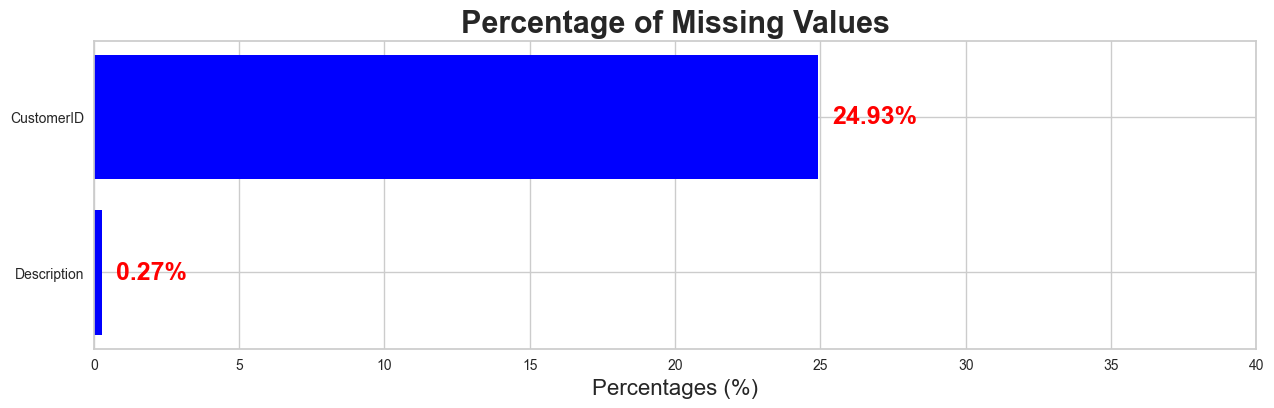

In [12]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='blue')


for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='red')

ax.set_xlim([0, 40])

plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [13]:
df = df.dropna(subset=['CustomerID', 'Description'])

In [14]:
# for Total sum
df.isnull().sum().sum()

0

### 3-2 Handling Duplicates

In [15]:
print(f"The Dataset contains >>> ({df.duplicated().sum()}) duplicate rows that need to be removed.")

The Dataset contains >>> (5225) duplicate rows that need to be removed.


In [16]:
df.drop_duplicates(inplace=True)

In [17]:
duplicate_rows = df[df.duplicated(keep=False)]

if duplicate_rows.empty:
    print("No duplicate rows found.")
else:
    print("Duplicate rows found.")


No duplicate rows found.


In [18]:
df.shape[0]

401604

### 3-3 Check

In [19]:
print(df["Quantity"].min())
print(df["UnitPrice"].min())

-80995
0.0


In [20]:
df = df.loc[df["Quantity"] >0 ]

In [21]:
print(df["Quantity"].min())

1


### 3-4 Correcting StockCode Anomalies

Stock Code Anomalies: We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'POST'. These anomalies might represent services or non-product transactions (perhaps postage fees) rather than actual products. To maintain the focus of the project, which is clustering based on product purchases and creating a recommendation system, these anomalies should be further investigated and possibly treated appropriately to ensure data integrity.

In [22]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()
unique_stock_codes

3665

In [23]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100
top_10_stock_codes

85123A    0.515110
22423     0.436430
85099B    0.411222
84879     0.355204
47566     0.353931
20725     0.332033
22720     0.293330
POST      0.279835
23203     0.277798
20727     0.274487
Name: StockCode, dtype: float64

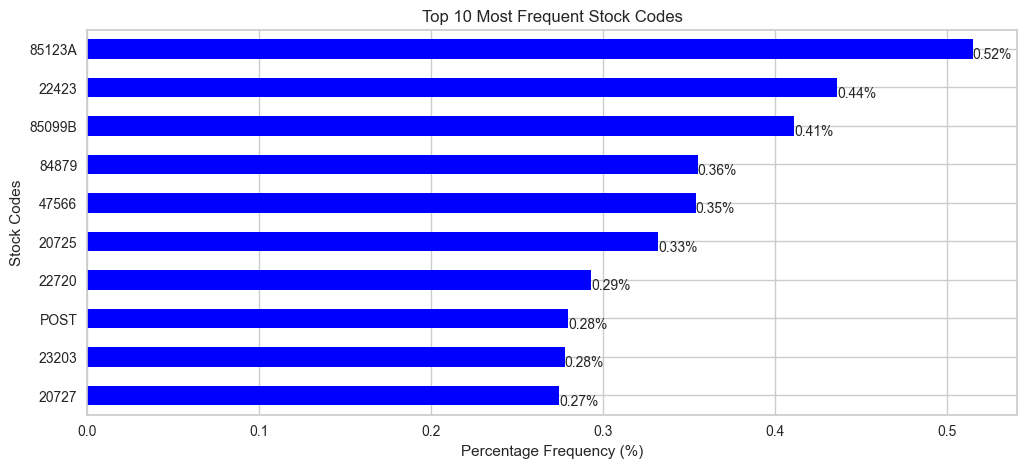

In [24]:
# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='blue')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [25]:
unique_stock_codes = df['StockCode'].unique()
unique_stock_codes

array(['85123A', 71053, '84406B', ..., '90214Z', 90089, 23843],
      dtype=object)

In [26]:
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()
numeric_char_counts_in_unique_codes

5    3659
0       5
1       1
dtype: int64

Inference:
The output indicates the following:

A majority of the unique stock code contain exactly 5 numeric characters, which seems to be the standard format for representing product codes in this dataset.
There are a few anomalies: 5 stock codes contain no numeric characters and 1 stock code contains only 1 numeric character. These are clearly deviating from the standard format and we will treat them as Outliers and we will remove them

In [27]:
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)


Anomalous stock codes:
----------------------
POST
C2
M
BANK CHARGES
PADS
DOT


In [28]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100
print(f"{percentage_anomalous:.2f}%")

0.39%


Based on the analysis, we find that a very small proportion of the records, 0.39%, have anomalous stock codes, which deviate from the typical format observed in the majority of the data.So we will remove them


In [29]:
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [30]:
df.shape[0]

391183

### 3-5 Treating Zero Unit Prices

In [31]:
df['UnitPrice'].describe()

count    391183.000000
mean          2.874130
std           4.284639
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [32]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


<b>Inferences on UnitPrice:<b>

The transactions with a unit price of zero are relatively few in number (33 transactions).
These transactions have a large variability in the quantity of items involved, ranging from 1 to 12540, with a substantial standard deviation.
Including these transactions in the clustering analysis might introduce noise and could potentially distort the customer behavior patterns identified by the clustering algorithm.

<b>Strategy:<b/>
    
Given the small number of these transactions and their potential to introduce noise in the data analysis, the strategy should be to remove these transactions from the dataset. This would help in maintaining a cleaner and more consistent dataset, which is essential for building an accurate and reliable clustering model and recommendation system.

In [33]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

In [34]:
df.shape[0]

391150

In [35]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

<b>In K-means clustering, the algorithm is sensitive to both the scale of data and the presence of outliers, as they can significantly influence the position of centroids, potentially leading to incorrect cluster assignments. However, considering the context of this project where the final goal is to understand customer behavior and preferences through K-means clustering, it would be more prudent to address the issue of outliers after the feature engineering phase where we create a customer-centric dataset. At this stage, the data is transactional, and removing outliers might eliminate valuable information that could play a crucial role in segmenting customers later on. Therefore, we will postpone the outlier treatment and proceed to the next stage for now<b>

# 4 - Feature Engineering

## 4-1 RFM Features

RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:

<B>Recency (R):<B>

This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.

<b>Frequency (F):<B>

This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.

<b>Monetary (M):<B>

This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

<b>Together, these metrics help in understanding a customer's buying behavior and preferences, which is pivotal in personalizing marketing strategies and creating a recommendation system.<B>

### 4-1-1 Recency (R)

In this step, we focus on understanding how recently a customer has made a purchase. This is a crucial aspect of customer segmentation as it helps in identifying the engagement level of customers. Here, I am going to define the following feature:

Days Since Last Purchas: This feature represents the number of days that have passed since the customer's last purchase. A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement. By understanding the recency of purchases, businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.


In [36]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

In [37]:
# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()


# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [38]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


Note:
I've named the
customer-centric dataframe as customer_data, which will eventually contain all the customer-based features we plan to create.



### 4-1-2 Frequency (F)

<b>In this step, I am going to create two features that quantify the frequency of a customer's engagement with the retailer:<B>

<B>Total Transactions:
    
    This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.
    
    
<B>Total Products Purchased:<B>
    
    This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.
    
    
These features will be crucial in segmenting customers based on their buying frequency, which is a key aspect in determining customer segments for targeted marketing and personalized recommendations.

In [39]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,1,74215
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


### 4-1-3 Monetary (M)

<B>In this step, I am going to create two features that represent the monetary aspect of customer's transactions:<B>

<B>Total Spend:<B>
    
    This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.
    
<B>Average Transaction Value: <B>
    
    This feature is calculated as the Total Spend divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.


In [40]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,1,74215,77183.60,77183.600000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


# 4-2 Product Diversity


In this step, we are going to understand the diversity in the product purchase behavior of customers. Understanding product diversity can help in crafting personalized marketing strategies and product recommendations. Here, I am going to define the following feature:

<B>Unique Products Purchased:<B>

This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [41]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,1,74215,77183.60,77183.600000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


## 4-3 Behavioral Features

In this step, we aim to understand and capture the shopping patterns and behaviors of customers. These features will give us insights into the customers' preferences regarding when they like to shop, which can be crucial information for personalizing their shopping experience. Here are the features I am planning to introduce:

<b>Average Days Between Purchases:<B>

This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.

<B>Favorite Shopping Day:<B>

This denotes the day of the week when the customer shops the most. This information can help in identifying the preferred shopping days of different customer segments, which can be used to optimize marketing strategies and promotions for different days of the week.

<B>Favorite Shopping Hour: <b>

This refers to the hour of the day when the customer shops the most. Identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most active.
By including these behavioral features in our dataset, we can create a more rounded view of our customers, which will potentially enhance the effectiveness of the clustering algorithm, leading to more meaningful customer segments.

In [42]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)


# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]


# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
1,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
2,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
3,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16
4,12352.0,36,7,526,1385.74,197.962857,57,3.421053,1,14


## 4-4 Geographic Features

In this step, we will introduce a geographic feature that reflects the geographical location of customers. Understanding the geographic distribution of customers is pivotal for several reasons:

<B>Country:<B> 
    
   
This feature identifies the country where each customer is located. Including the country data can help us understand region-specific buying patterns and preferences. Different regions might have varying preferences and purchasing behaviors which can be critical in personalizing marketing strategies and inventory planning. Furthermore, it can be instrumental in logistics and supply chain optimization, particularly for an online retailer where shipping and delivery play a significant role.

In [43]:
df['Country'].value_counts(normalize=True).head()

United Kingdom    0.891914
Germany           0.022096
France            0.020501
EIRE              0.018218
Spain             0.006179
Name: Country, dtype: float64

Inference:
Given that a substantial portion (89%) of transactions are originating from the United Kingdom, we might consider creating a binary feature indicating whether the transaction is from the UK or not. This approach can potentially streamline the clustering process without losing critical geographical information, especially when considering the application of algorithms like K-means which are sensitive to the dimensionality of the feature space.

<B>Methodology:<B>


First, I will group the data by CustomerID and Country and calculate the number of transactions per country for each customer.

Next, I will identify the main country for each customer (the country from which they have the maximum transactions).

Then, I will create a binary column indicating whether the customer is from the UK or not.

Finally, I will merge this information with the customer_data dataframe to include the new feature in our analysis.

In [44]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
1,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
2,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
3,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0
4,12352.0,36,7,526,1385.74,197.962857,57,3.421053,1,14,0


In [45]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

1    3847
0     414
Name: Is_UK, dtype: int64

## 4-5 Seasonality & Trends

In this step, I will delve into the seasonality and trends in customers' purchasing behaviors, which can offer invaluable insights for tailoring marketing strategies and enhancing customer satisfaction. Here are the features I am looking to introduce:

<b>Monthly_Spending_Mean:<b>
    
    This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.
    
    
<B>Monthly_Spending_Std:<B>
    
    This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more.
    
    
<B>Spending_Trend:<b>
    
    This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction. Conversely, a negative trend might signal decreasing interest or satisfaction, highlighting a need for re-engagement strategies. A near-zero value signifies stable spending habits. Recognizing these trends can help in developing strategies to either maintain or alter customer spending patterns, enhancing the effectiveness of marketing campaigns.

    
    <B> By incorporating these detailed insights into our customer segmentation model, we can create more precise and actionable customer groups, facilitating the development of highly targeted marketing strategies and promotions.<B>



In [46]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,615.714286,341.070789,4.486071
1,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,359.310000,203.875689,-100.884000
2,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,1457.550000,0.000000,0.000000
3,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,294.400000,0.000000,0.000000
4,12352.0,36,7,526,1385.74,197.962857,57,3.421053,1,14,0,346.435000,120.042154,-2.682000


We've done a great job so far! We have created a dataset that focuses on our customers, using a variety of new features that give us a deeper understanding of their buying patterns and preferences.

In [47]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,615.714286,341.070789,4.486071
1,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,359.31,203.875689,-100.884
2,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,1457.55,0.0,0.0
3,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,294.4,0.0,0.0
4,12352.0,36,7,526,1385.74,197.962857,57,3.421053,1,14,0,346.435,120.042154,-2.682
5,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,89.0,0.0,0.0
6,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,1079.4,0.0,0.0
7,12355.0,214,1,240,459.4,459.4,13,0.0,0,13,0,459.4,0.0,0.0
8,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,829.143333,991.462585,-944.635
9,12357.0,33,1,2708,6207.67,6207.67,131,0.0,6,16,0,6207.67,0.0,0.0


In [48]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4261 entries, 0 to 4260
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4261 non-null   string 
 1   Days_Since_Last_Purchase        4261 non-null   Int64  
 2   Total_Transactions              4261 non-null   Int64  
 3   Total_Products_Purchased        4261 non-null   Int64  
 4   Total_Spend                     4261 non-null   Float64
 5   Average_Transaction_Value       4261 non-null   Float64
 6   Unique_Products_Purchased       4261 non-null   Int64  
 7   Average_Days_Between_Purchases  4261 non-null   Float64
 8   Day_Of_Week                     4261 non-null   Int64  
 9   Hour                            4261 non-null   Int64  
 10  Is_UK                           4261 non-null   Int64  
 11  Monthly_Spending_Mean           4261 non-null   Float64
 12  Monthly_Spending_Std            42

# 5 - Outlier Detection and Treatment

In this section, I will identify and handle outliers in our dataset. Outliers are data points that are significantly different from the majority of other points in the dataset. These points can potentially skew the results of our analysis, especially in k-means clustering where they can significantly influence the position of the cluster centroids. Therefore, it is essential to identify and treat these outliers appropriately to achieve more accurate and meaningful clustering results.

Given the multi-dimensional nature of the data, it would be prudent to use algorithms that can detect outliers in multi-dimensional spaces. I am going to use the Isolation Forest algorithm for this task. This algorithm works well for multi-dimensional data and is computationally efficient. It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Let's proceed with this approach:



In [49]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,615.714286,341.070789,4.486071,1,0
1,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,359.31,203.875689,-100.884,-1,1
2,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,1457.55,0.0,0.0,-1,1
3,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,294.4,0.0,0.0,1,0
4,12352.0,36,7,526,1385.74,197.962857,57,3.421053,1,14,0,346.435,120.042154,-2.682,1,0


After applying the Isolation Forest algorithm, we have identified the outliers and marked them in a new column named Is_Outlier. We have also calculated the outlier scores which represent the anomaly score of each record.

Now let's visualize the distribution of these scores and the number of inliers and outliers detected by the model:

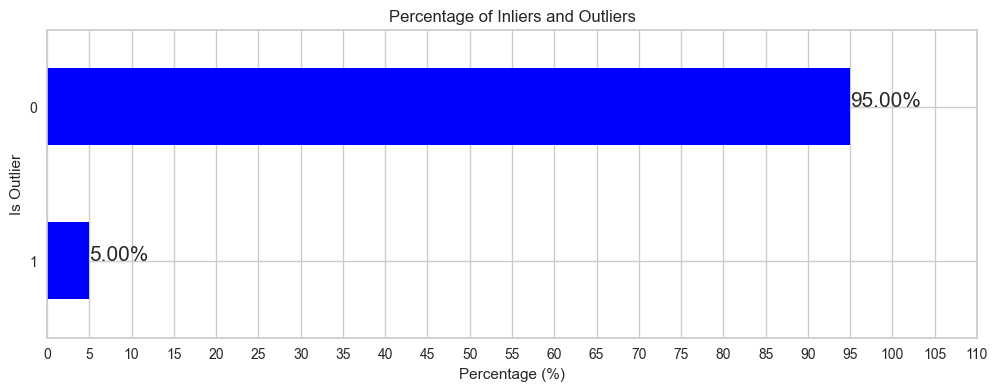

In [50]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='blue')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

<B>Inference:<B>


From the above plot, we can observe that about 5% of the customers have been identified as outliers in our dataset. This percentage seems to be a reasonable proportion, not too high to lose a significant amount of data, and not too low to retain potentially noisy data points. It suggests that our isolation forest algorithm has worked well in identifying a moderate percentage of outliers, which will be critical in refining our customer segmentation.
    
    
<B>Strategy:<B>
    
    
Considering the nature of the project (customer segmentation using clustering), it is crucial to handle these outliers to prevent them from affecting the clusters' quality significantly. Therefore, I will separate these outliers for further analysis and remove them from our main dataset to prepare it for the clustering analysis.

    
    
Let's proceed with the following steps:

Separate the identified outliers for further analysis and save them as a separate file (optional).
Remove the outliers from the main dataset to prevent them from influencing the clustering process.
Drop the Outlier_Scores and Is_Outlier columns as they were auxiliary columns used for the outlier detection process.
Let's implement these steps:

In [51]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

We have successfully separated the outliers for further analysis and cleaned our main dataset by removing these outliers. This cleaned dataset is now ready for the next steps in our customer segmentation project, which includes scaling the features and applying clustering algorithms to identify distinct customer segments.

In [52]:
customer_data_cleaned.shape[0]

4048

# 6 - Correlation Analysis


Before we proceed to KMeans clustering, it's essential to check the correlation between features in our dataset. The presence of multicollinearity, where features are highly correlated, can potentially affect the clustering process by not allowing the model to learn the actual underlying patterns in the data, as the features do not provide unique information. This could lead to clusters that are not well-separated and meaningful.

If we identify multicollinearity, we can utilize dimensionality reduction techniques like PCA. These techniques help in neutralizing the effect of multicollinearity by transforming the correlated features into a new set of uncorrelated variables, preserving most of the original data's variance. This step not only enhances the quality of clusters formed but also makes the clustering process more computationally efficient.



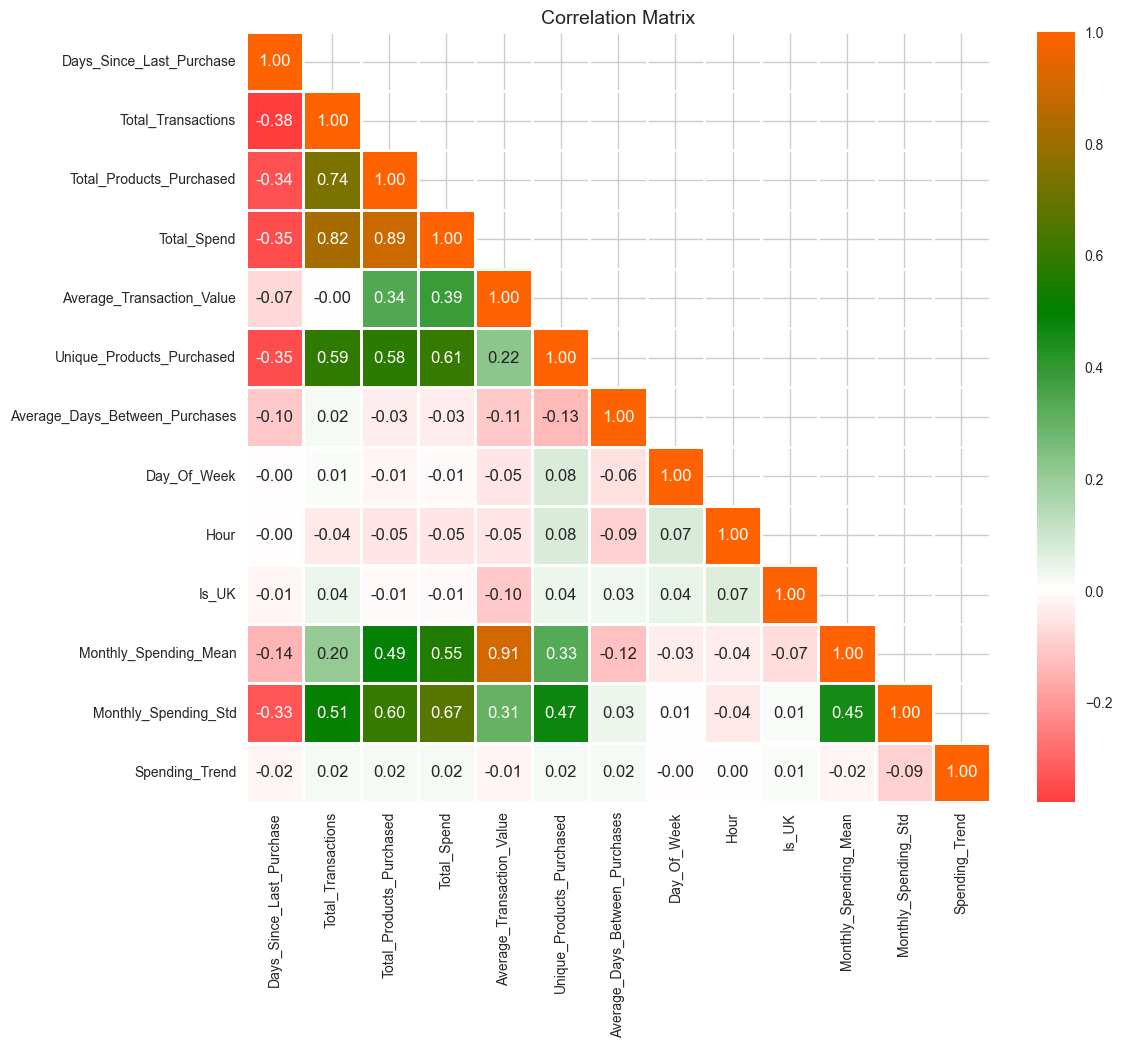

In [53]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['blue', 'red', 'white', 'green', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

<B>Inference:<B>
    
    
Looking at the heatmap, we can see that there are some pairs of variables that have high correlations, for instance:

    
Monthly_Spending_Mean and Average_Transaction_Value
    
Total_Spend and Total_Products_Purchased
    
Total_Transactions and Total_Spend
    
Cancellation_Rate and Cancellation_Frequency
    
Total_Transactions and Total_Products_Purchased
    
    
These high correlations indicate that these variables move closely together, implying a degree of multicollinearity.

Before moving to the next steps, considering the impact of multicollinearity on KMeans clustering, it might be beneficial to treat this multicollinearity possibly through dimensionality reduction techniques such as PCA to create a set of uncorrelated variables. This will help in achieving more stable clusters during the KMeans clustering process.    

# 7 -  Feature Scaling


Before we move forward with the clustering and dimensionality reduction, it's imperative to scale our features. This step holds significant importance, especially in the context of distance-based algorithms like K-means and dimensionality reduction methods like PCA. Here's why:


For K-means Clustering: K-means relies heavily on the concept of 'distance' between data points to form clusters. When features are not on a similar scale, features with larger values can disproportionately influence the clustering outcome, potentially leading to incorrect groupings.

For PCA: PCA aims to find the directions where the data varies the most. When features are not scaled, those with larger values might dominate these components, not accurately reflecting the underlying patterns in the data.


<B>Methodology:<b>
    
    
Therefore, to ensure a balanced influence on the model and to reveal the true patterns in the data, I am going to standardize our data, meaning transforming the features to have a mean of 0 and a standard deviation of 1. However, not all features require scaling. Here are the exceptions and the reasons why they are excluded:

    
<B>CustomerID:<b>
    
    This feature is just an identifier for the customers and does not contain any meaningful information for clustering.
    
    
<B>Is_UK:<b>
    
    This is a binary feature indicating whether the customer is from the UK or not. Since it already takes a value of 0 or 1, scaling it won't make any significant difference.
    
    
<B>Day_Of_Week:<B>
    
    This feature represents the most frequent day of the week that the customer made transactions. Since it's a categorical feature represented by integers (1 to 7), scaling it would not be necessary.
    
I will proceed to scale the other features in the dataset to prepare it for PCA and K-means clustering.

In [54]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12347.0,-0.909898,0.885119,1.908080,2.163930,1.268243,0.776610,-0.117062,1,0.646419,0,0.912227,1.567879,0.076867
1,12350.0,2.202677,-0.671337,-0.546954,-0.600431,-0.134642,-0.661754,-0.348905,2,1.515468,0,-0.300457,-0.713663,0.046811
2,12352.0,-0.566302,0.885119,-0.188793,0.150854,-0.555695,0.016096,0.044409,1,0.646419,0,-0.104070,0.089341,0.028841
3,12353.0,1.131466,-0.671337,-0.737974,-0.741829,-1.031436,-0.860149,-0.348905,3,1.949992,0,-1.075665,-0.713663,0.046811
4,12354.0,1.414427,-0.671337,-0.184451,-0.060032,3.292734,0.032629,-0.348905,3,0.211895,0,2.662241,-0.713663,0.046811


# 8 -  Dimensionality Reduction

<B>Why We Need Dimensionality Reduction?<b>


Multicollinearity Detected:
    In the previous steps, we identified that our dataset contains multicollinear features. Dimensionality reduction can help us remove redundant information and alleviate the multicollinearity issue.
    
Better Clustering with K-means:
    Since K-means is a distance-based algorithm, having a large number of features can sometimes dilute the meaningful underlying patterns in the data. By reducing the dimensionality, we can help K-means to find more compact and well-separated clusters.
    
Noise Reduction: 
    By focusing only on the most important features, we can potentially remove noise in the data, leading to more accurate and stable clusters.
    
Enhanced Visualization:
    In the context of customer segmentation, being able to visualize customer groups in two or three dimensions can provide intuitive insights. Dimensionality reduction techniques can facilitate this by reducing the data to a few principal components which can be plotted easily.
    
Improved Computational Efficiency:
    
   Reducing the number of features can speed up the computation time during the modeling process, making our clustering algorithm more efficient.
    
Let's proceed to select an appropriate dimensionality reduction method to our data.

<B>Methodology<B>
    
   
I will apply PCA on all the available components and plot the cumulative variance explained by them. This process will allow me to visualize how much variance each additional principal component can explain, thereby helping me to pinpoint the optimal number of components to retain for the analysis:

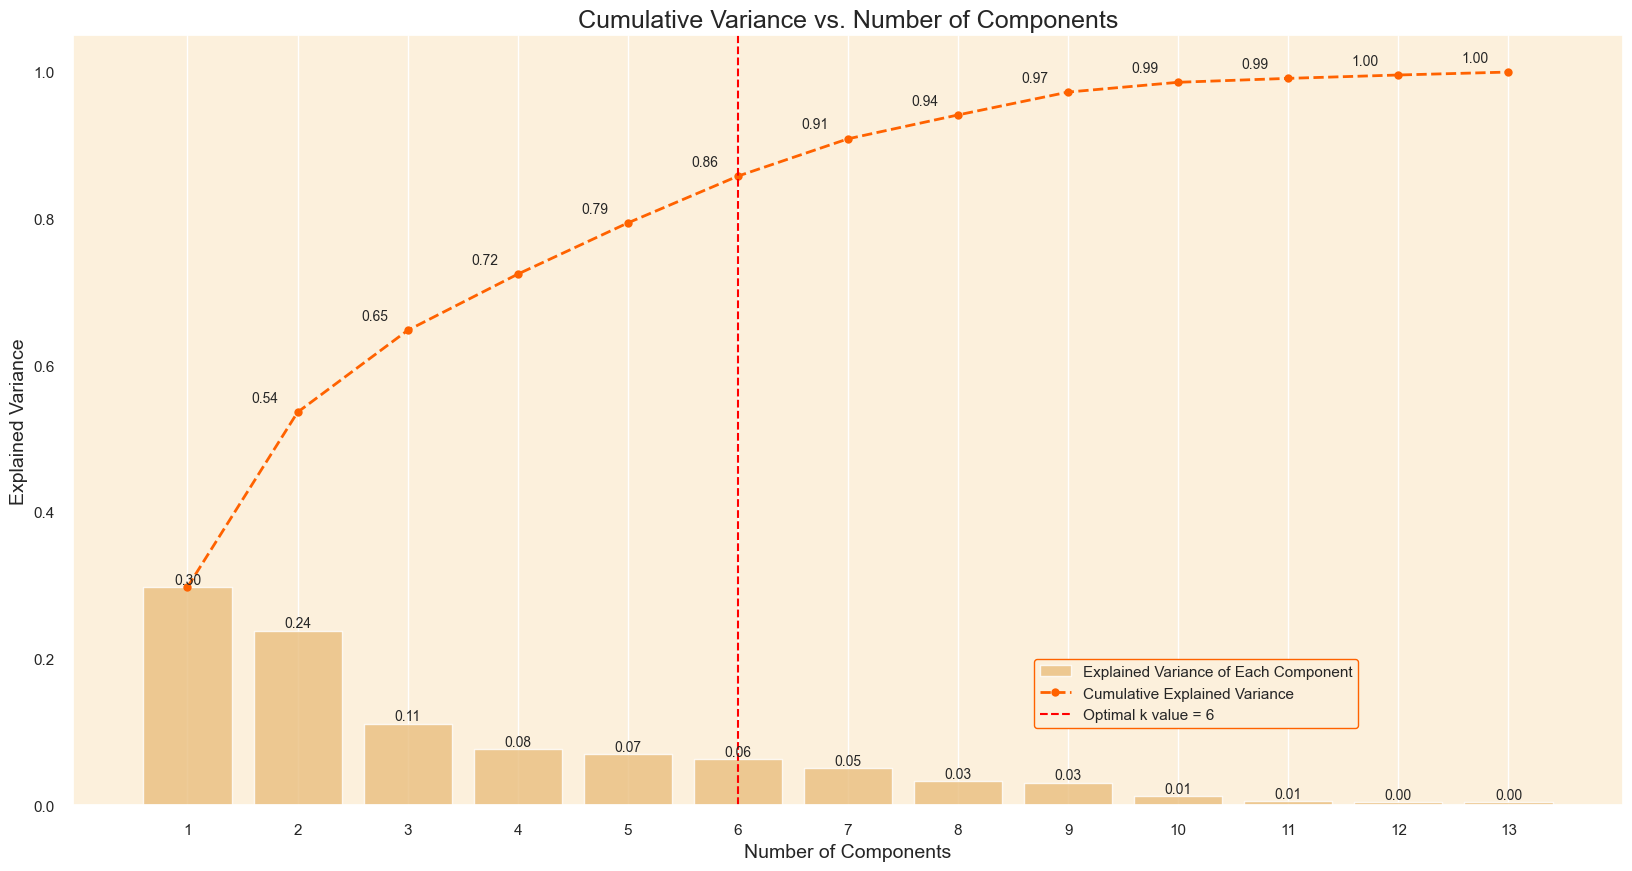

In [55]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))


# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)


# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

<B>Conclusion<b>
The plot and the cumulative explained variance values indicate how much of the total variance in the dataset is captured by each principal component, as well as the cumulative variance explained by the first n components.

Here, we can observe that:

The first component explains approximately 28% of the variance.

The first two components together explain about 49% of the variance.

The first three components explain approximately 61% of the variance, and so on.

To choose the optimal number of components, we generally look for a point where adding another component doesn't significantly increase the cumulative explained variance, often referred to as the "elbow point" in the curve.

From the plot, we can see that the increase in cumulative variance starts to slow down after the 6th component (which captures about 81% of the total variance).

Considering the context of customer segmentation, we want to retain a sufficient amount of information to identify distinct customer groups effectively. Therefore, retaining the first 6 components might be a balanced choice, as they together explain a substantial portion of the total variance while reducing the dimensionality of the dataset.

In [56]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [57]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12347.0,3.752680,1.615230,0.144979,-0.440564,0.035274,0.551141
12350.0,-1.900294,0.471807,0.874058,-1.398483,0.007220,0.111534
12352.0,0.272324,1.481340,-0.968660,-0.598554,-0.058826,0.432047
12353.0,-2.345515,-0.615388,-0.293796,-1.621681,-0.093615,0.609921
12354.0,0.777682,-0.197592,4.297716,0.094498,0.503802,0.326236


Now, let's extract the coefficients corresponding to each principal component to better understand the transformation performed by PCA:



In [58]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.224320,0.001812,0.269856,-0.087915,-0.016218,-0.378947
Total_Transactions,0.370729,-0.010449,-0.378069,-0.051336,-0.002639,-0.159761
Total_Products_Purchased,0.428894,0.013335,-0.097262,-0.005182,0.019956,-0.100778
Total_Spend,0.451882,0.011600,-0.080132,0.003923,0.020897,-0.094728
Average_Transaction_Value,0.249068,0.047689,0.628446,0.108779,0.075073,0.158033
Unique_Products_Purchased,0.348538,-0.049452,-0.136868,-0.252909,0.006428,-0.037483
Average_Days_Between_Purchases,-0.028417,0.043798,-0.240707,0.653737,0.040391,0.563131
Day_Of_Week,0.014243,-0.994031,0.049326,0.090145,0.010375,-0.001914
Hour,-0.021116,-0.058337,-0.012566,-0.677612,-0.028707,0.669682
Is_UK,-0.001302,-0.007507,-0.022566,-0.012192,-0.000711,0.012158


# 9 -  K-Means Clustering

K-Means:
K-Means is an unsupervised machine learning algorithm that clusters data into a specified number of groups (K) by minimizing the within-cluster sum-of-squares (WCSS), also known as inertia. The algorithm iteratively assigns each data point to the nearest centroid, then updates the centroids by calculating the mean of all assigned points. The process repeats until convergence or a stopping criterion is reached.

Drawbacks of K-Means:
Here are the main drawbacks of the K-means clustering algorithm and their corresponding solutions:

1️⃣ Inertia is influenced by the number of dimensions: The value of inertia tends to increase in high-dimensional spaces due to the curse of dimensionality, which can distort the Euclidean distances between data points.
Solution: Performing dimensionality reduction, such as PCA, before applying K-means to alleviate this issue and speed up computations.

2️⃣ Dependence on Initial Centroid Placement: The K-means algorithm might find a local minimum instead of a global minimum, based on where the centroids are initially placed.
Solution: To enhance the likelihood of locating the global minimum, we can employ the k-means++ initialization method.

3️⃣ Requires specifying the number of clusters: K-means requires specifying the number of clusters (K) beforehand, which may not be known in advance.
Solution: Using methods such as the elbow method and silhouette analysis to estimate the optimal number of clusters.

4️⃣ Sensitivity to unevenly sized or sparse clusters: K-means might struggle with clusters of different sizes or densities.
Solution: Increasing the number of random initializations (n_init) or consider using algorithms that handle unevenly sized clusters better, like GMM or DBSCAN.

5️⃣ Assumes convex and isotropic clusters: K-means assumes that clusters are spherical and have similar variances, which is not always the case. It may struggle with elongated or irregularly shaped clusters.
Solution: Considering using clustering algorithms that do not make these assumptions, such as DBSCAN or Gaussian Mixture Model (GMM).

Taking into account the aforementioned considerations, I initially applied PCA to the dataset. For the KMeans algorithm, I will set the init parameter to k-means++ and n_init to 10. To determine the optimal number of clusters, I will employ the elbow method and silhouette analysis. Additionally, it might be beneficial to explore the use of alternative clustering algorithms such as GMM and DBSCAN in future analyses to potentially enhance the segmentation results.

### 9-1 Determining the Optimal Number of Clusters

To ascertain the optimal number of clusters (k) for segmenting customers, I will explore two renowned methods:

Elbow Method

Silhouette Method

It's common to utilize both methods in practice to corroborate the results.

<B>Elbow Method<B>

What is the Elbow Method?
The Elbow Method is a technique for identifying the ideal number of clusters in a dataset. It involves iterating through the data, generating clusters for various values of k. The k-means algorithm calculates the sum of squared distances between each data point and its assigned cluster centroid, known as the inertia or WCSS score. By plotting the inertia score against the k value, we create a graph that typically exhibits an elbow shape, hence the name "Elbow Method". The elbow point represents the k-value where the reduction in inertia achieved by increasing k becomes negligible, indicating the optimal stopping point for the number of clusters.
    

Utilizing the YellowBrick Library
In this section, I will employ the YellowBrick library to facilitate the implementation of the Elbow method. YellowBrick, an extension of the Scikit-Learn API, is renowned for its ability to rapidly generate insightful visualizations in the field of machine learning.    

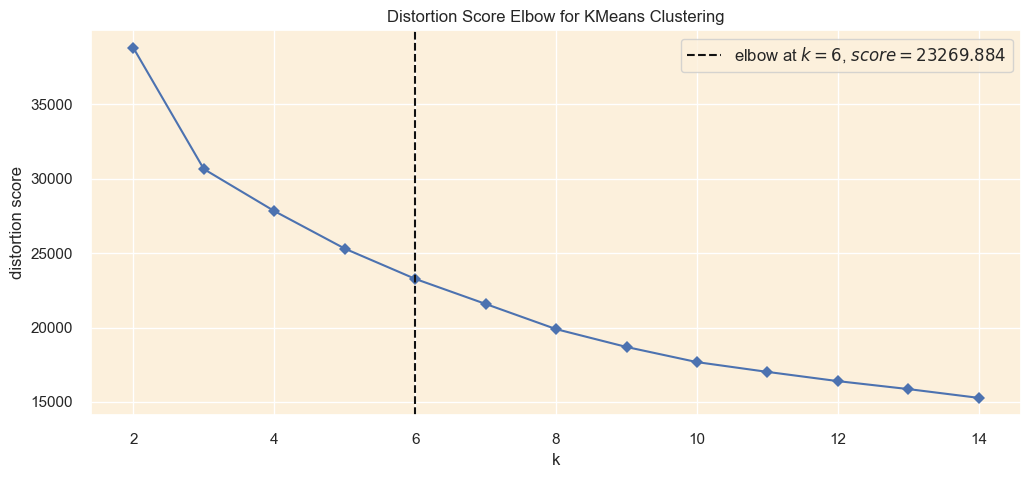

In [59]:
# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

Optimal k Value: Elbow Method Insights
The optimal value of k for the KMeans clustering algorithm can be found at the elbow point. Using the YellowBrick library for the Elbow method, we observe that the suggested optimal k value is 6. However, we don't have a very distinct elbow point in this case, which is common in real-world data. From the plot, we can see that the inertia continues to decrease significantly up to k=6, indicating that the optimum value of k could be between 4 and 8. To choose the best k within this range, we can employ the silhouette analysis, another cluster quality evaluation method. Additionally, incorporating business insights can help determine a practical k value.

### 9-1-2 Silhouette Method


In [61]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)    

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()


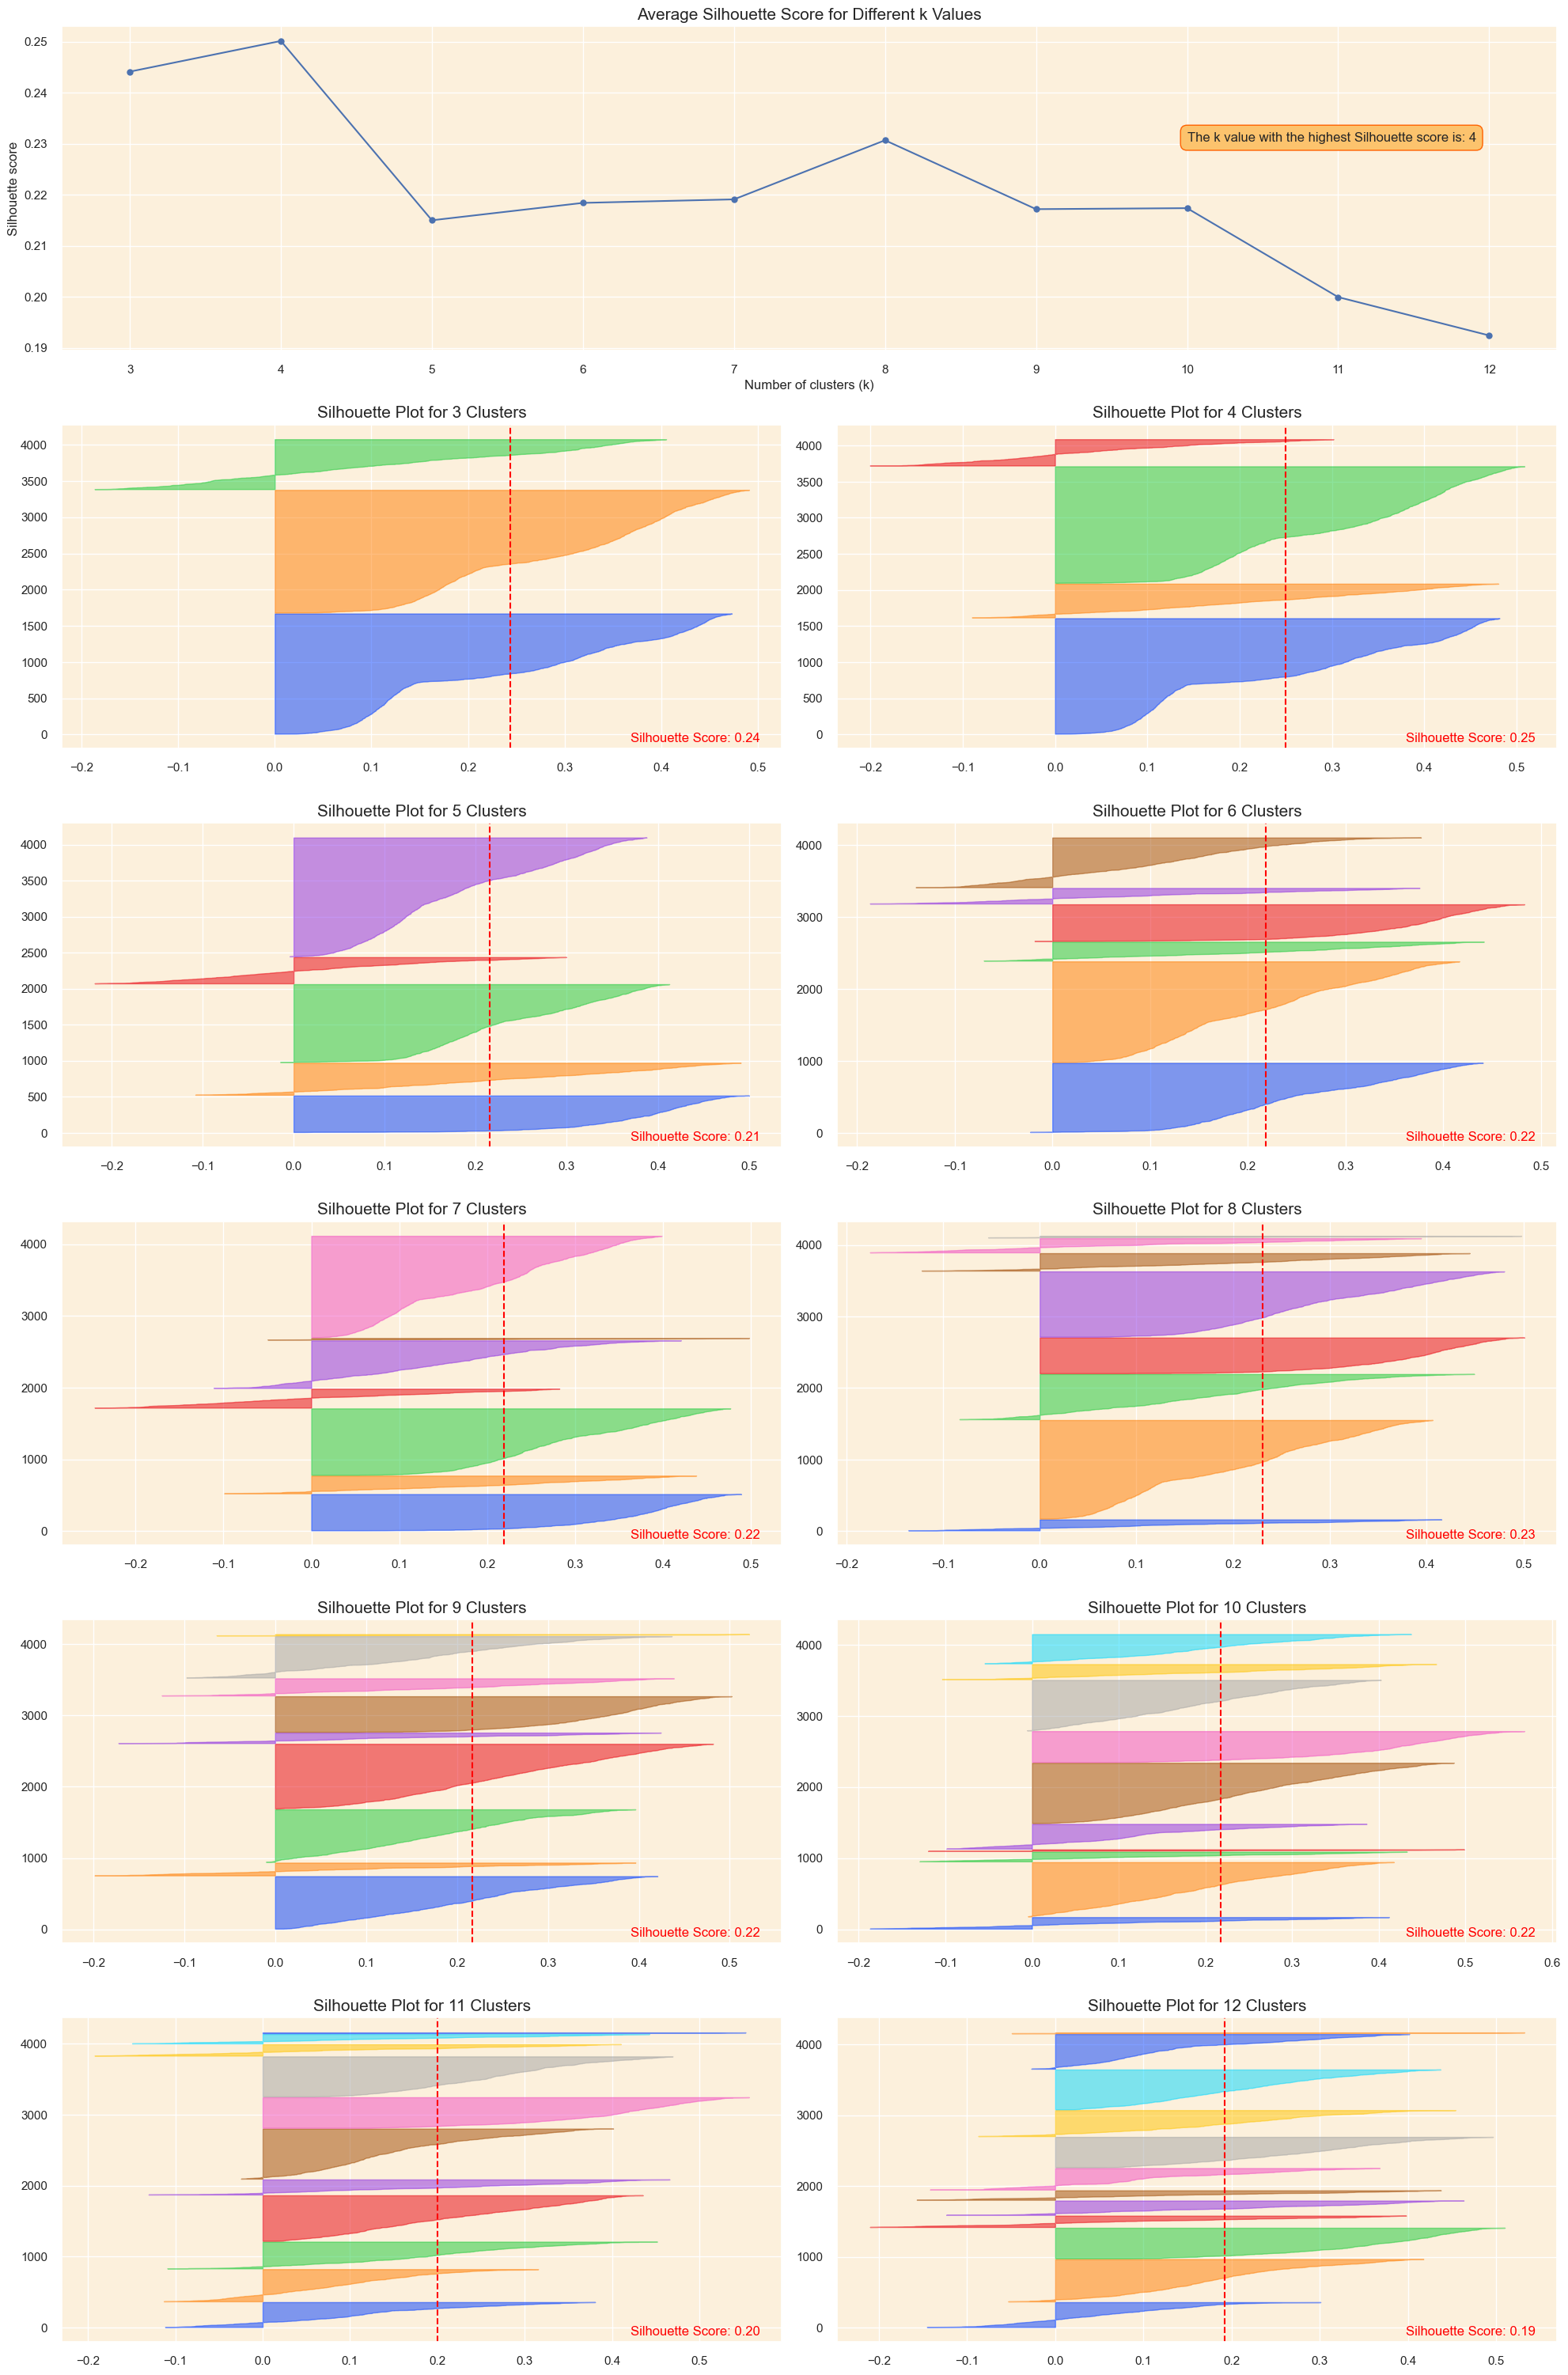

In [62]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

Guidelines to Interpret Silhouette Plots and Determine the Optimal K:
To interpret silhouette plots and identify the optimal number of clusters (( k )), consider the following criteria:

1️⃣ Analyze the Silhouette Plots:

Silhouette Score Width:

Wide Widths (closer to +1): Indicate that the data points in the cluster are well separated from points in other clusters, suggesting well-defined clusters.
Narrow Widths (closer to -1): Show that data points in the cluster are not distinctly separated from other clusters, indicating poorly defined clusters.
Average Silhouette Score:

High Average Width: A cluster with a high average silhouette score indicates well-separated clusters.
Low Average Width: A cluster with a low average silhouette score indicates poor separation between clusters.
2️⃣ Uniformity in Cluster Size:

2.1 Cluster Thickness:

Uniform Thickness: Indicates that clusters have a roughly equal number of data points, suggesting a balanced clustering structure.
Variable Thickness: Signifies an imbalance in the data point distribution across clusters, with some clusters having many data points and others too few.

3️⃣ Peaks in Average Silhouette Score:
Clear Peaks: A clear peak in the average silhouette score plot for a specific ( k ) value indicates this ( k ) might be optimal.
4️⃣ Minimize Fluctuations in Silhouette Plot Widths:
Uniform Widths: Seek silhouette plots with similar widths across clusters, suggesting a more balanced and optimal clustering.
Variable Widths: Avoid wide fluctuations in silhouette plot widths, indicating that clusters are not well-defined and may vary in compactness.
5️⃣ Optimal Cluster Selection:
Maximize the Overall Average Silhouette Score: Choose the ( k ) value that gives the highest average silhouette score across all clusters, indicating well-defined clusters.
Avoid Below-Average Silhouette Scores: Ensure most clusters have above-average silhouette scores to prevent suboptimal clustering structures.
6️⃣ Visual Inspection of Silhouette Plots:
Consistent Cluster Formation: Visually inspect the silhouette plots for each ( k ) value to evaluate the consistency and structure of the formed clusters.
Cluster Compactness: Look for more compact clusters, with data points having silhouette scores closer to +1, indicating better clustering.

Optimal k Value: Silhouette Method Insights
Based on above guidelines and after carefully considering the silhouette plots, it's clear that choosing ( k = 3 ) is the better option. This choice gives us clusters that are more evenly matched and well-defined, making our clustering solution stronger and more reliable.

## 9-2 Clustering Model - K-means


In [63]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [64]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,615.714286,341.070789,4.486071,0
1,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,294.4,0.0,0.0,2
2,12352.0,36,7,526,1385.74,197.962857,57,3.421053,1,14,0,346.435,120.042154,-2.682,2
3,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,89.0,0.0,0.0,1
4,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,1079.4,0.0,0.0,1


# 10- Clustering Evaluation



<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">

After determining the optimal number of clusters (which is 3 in our case) using elbow and silhouette analyses, I move onto the evaluation step to assess the quality of the clusters formed. This step is essential to validate the effectiveness of the clustering and to ensure that the clusters are __coherent__ and __well-separated__. The evaluation metrics and a visualization technique I plan to use are outlined below:
    
- 1️⃣ __3D Visualization of Top PCs__ 

    
- 2️⃣ __Cluster Distribution Visualization__ 
    
    
- 3️⃣ __Evaluation Metrics__ 
    
    * Silhouette Score
    * Calinski Harabasz Score
    * Davies Bouldin Score
       
____  
    
**Note**: We are using the PCA version of the dataset for evaluation because this is the space where the clusters were actually formed, capturing the most significant patterns in the data. Evaluating in this space ensures a more accurate representation of the cluster quality, helping us understand the true cohesion and separation achieved during clustering. This approach also aids in creating a clearer 3D visualization using the top principal components, illustrating the actual separation between clusters.

### Step 10.1 | 3D Visualization of Top Principal Components

In [66]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

In [67]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

### Step 10.2 | Cluster Distribution Visualization

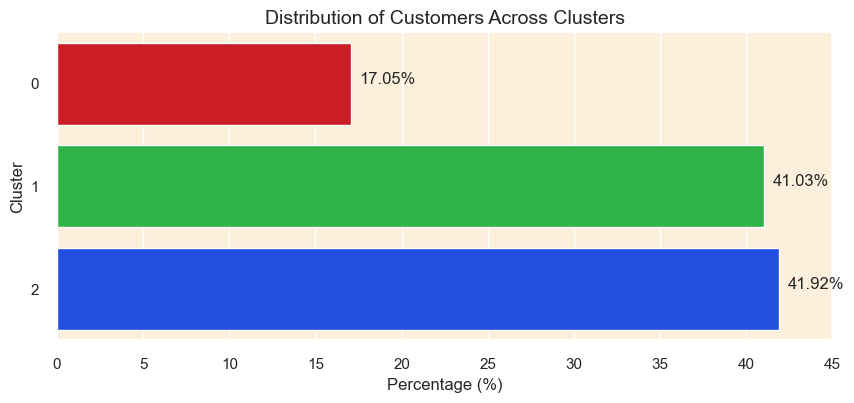

In [68]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()


Inference
The distribution of customers across the clusters, as depicted by the bar plot, suggests a fairly balanced distribution with clusters 0 and 1 holding around 41% of customers each and cluster 2 accommodating approximately 18% of the customers.

This balanced distribution indicates that our clustering process has been largely successful in identifying meaningful patterns within the data, rather than merely grouping noise or outliers. It implies that each cluster represents a substantial and distinct segment of the customer base, thereby offering valuable insights for future business strategies.

Moreover, the fact that no cluster contains a very small percentage of customers, assures us that each cluster is significant and not just representing outliers or noise in the data. This setup allows for a more nuanced understanding and analysis of different customer segments, facilitating effective and informed decision-making

### Step 10.3 | Evaluation Metrics

To further scrutinize the quality of our clustering, I will employ the following metrics:

Silhouette Score: A measure to evaluate the separation distance between the clusters. Higher values indicate better cluster separation. It ranges from -1 to 1.
Calinski Harabasz Score: This score is used to evaluate the dispersion between and within clusters. A higher score indicates better defined clusters.
Davies Bouldin Score: It assesses the average similarity between each cluster and its most similar cluster. Lower values indicate better cluster separation.

In [69]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4048         |
|    Silhouette Score     | 0.24412612813741205 |
| Calinski Harabasz Score | 1303.2533865286225  |
|  Davies Bouldin Score   | 1.3418157168877205  |
+-------------------------+---------------------+


Clustering Quality Inference
The Silhouette Score of approximately 0.236, although not close to 1, still indicates a fair amount of separation between the clusters. It suggests that the clusters are somewhat distinct, but there might be slight overlaps between them. Generally, a score closer to 1 would be ideal, indicating more distinct and well-separated clusters.
The Calinski Harabasz Score is 1257.17, which is considerably high, indicating that the clusters are well-defined. A higher score in this metric generally signals better cluster definitions, thus implying that our clustering has managed to find substantial structure in the data.
The Davies Bouldin Score of 1.37 is a reasonable score, indicating a moderate level of similarity between each cluster and its most similar one. A lower score is generally better as it indicates less similarity between clusters, and thus, our score here suggests a decent separation between the clusters.
In conclusion, the metrics suggest that the clustering is of good quality, with clusters being well-defined and fairly separated. However, there might still be room for further optimization to enhance cluster separation and definition, potentially by trying other clustering and dimensionality reduction algorithms.




Step 11 | Cluster Analysis and Profiling



In this section, I am going to analyze the characteristics of each cluster to understand the distinct behaviors and preferences of different customer segments and also profile each cluster to identify the key traits that define the customers in each cluster.




Step 11.1 | Radar Chart Approach
⬆️ Tabel of Contents

First of all, I am going to create radar charts to visualize the centroid values of each cluster across different features. This can give a quick visual comparison of the profiles of different clusters.To construct the radar charts, it's essential to first compute the centroid for each cluster. This centroid represents the mean value for all features within a specific cluster. Subsequently, I will display these centroids on the radar charts, facilitating a clear visualization of the central tendencies of each feature across the various clusters:


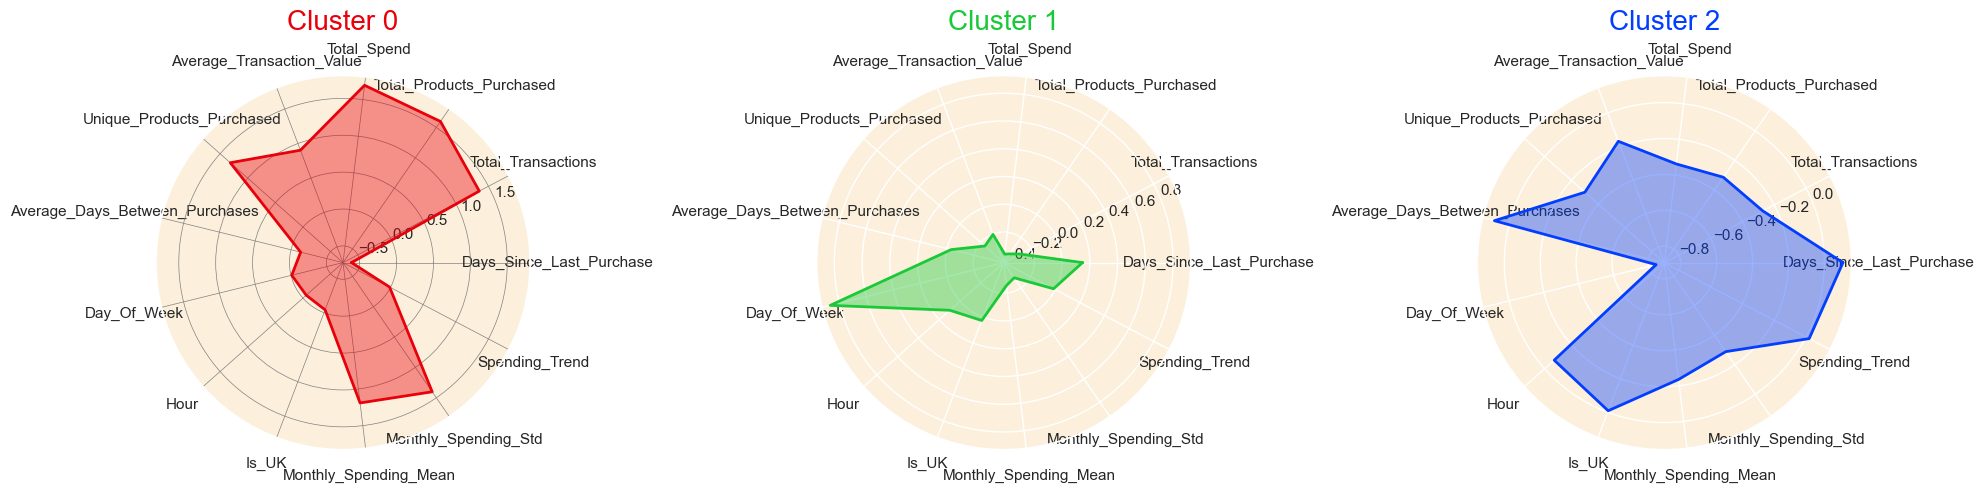

In [70]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

Customer Profiles Derived from Radar Chart Analysis


<B>Cluster 0 (Red Chart):<B>
    
    
🎯 Profile: Sporadic Shoppers with a Preference for Weekend Shopping

Customers in this cluster tend to spend less, with a lower number of transactions and products purchased.
They have a slight tendency to shop during the weekends, as indicated by the very high Day_of_Week value.
Their spending trend is relatively stable but on the lower side, and they have a low monthly spending variation (low Monthly_Spending_Std).
These customers have not engaged in many cancellations, showing a low cancellation frequency and rate.
The average transaction value is on the lower side, indicating that when they do shop, they tend to spend less per transaction.


<B>Cluster 1 (Green Chart):<B>
    
    
🎯 Profile: Infrequent Big Spenders with a High Spending Trend

Customers in this cluster show a moderate level of spending, but their transactions are not very frequent, as indicated by the high Days_Since_Last_Purchase and Average_Days_Between_Purchases.
They have a very high spending trend, indicating that their spending has been increasing over time.
These customers prefer shopping late in the day, as indicated by the high Hour value, and they mainly reside in the UK.
They have a tendency to cancel a moderate number of transactions, with a medium cancellation frequency and rate.
Their average transaction value is relatively high, meaning that when they shop, they tend to make substantial purchases.


<B>Cluster 2 (Blue Chart):<B>
    
    
🎯 Profile: Frequent High-Spenders with a High Rate of Cancellations

Customers in this cluster are high spenders with a very high total spend, and they purchase a wide variety of unique products.
They engage in frequent transactions, but also have a high cancellation frequency and rate.
These customers have a very low average time between purchases, and they tend to shop early in the day (low Hour value).
Their monthly spending shows high variability, indicating that their spending patterns might be less predictable compared to other clusters.
Despite their high spending, they show a low spending trend, suggesting that their high spending levels might be decreasing over time.

In the final phase of this project, I am set to develop a recommendation system to enhance the online shopping experience. This system will suggest products to customers based on the purchasing patterns prevalent in their respective clusters. Earlier in the project, during the customer data preparation stage, I isolated a small fraction (5%) of the customers identified as outliers and reserved them in a separate dataset called outliers_data.

Now, focusing on the core 95% of the customer group, I analyze the cleansed customer data to pinpoint the top-selling products within each cluster. Leveraging this information, the system will craft personalized recommendations, suggesting the top three products popular within their cluster that they have not yet purchased. This not only facilitates targeted marketing strategies but also enriches the personal shopping experience, potentially boosting sales. For the outlier group, a basic approach could be to recommend random products, as a starting point to engage them.